In [1]:
%matplotlib widget
import sys
import json 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
from tqdm.auto import tqdm
from pathlib import Path

crs = "ESRI:102004"
datasets = Path("/work/pi_kandread_umass_edu/Datasets/")
proj_root = Path('/work/pi_kandread_umass_edu/tss-ml/')
run_dir = proj_root / 'runs/CONUS/train_all_sites_20241119_011923/'
fig_dir = run_dir / 'figures/inference'
fig_dir.mkdir(exist_ok=True, parents=True)

outlines = gpd.read_file(datasets / 'Mapping/US_outlines/Contiguous_cb_2018_us_nation_20m/cb_2018_us_nation_20m.shp')
outlines = outlines.to_crs(crs)

gdw = gpd.read_file(datasets / 'GlobalDamWatch/GDW_v1_0_shp/GDW_reservoirs_v1_0.shp')
gdw = gdw.set_index('GDW_ID').to_crs(crs)

matchups = pd.read_parquet(proj_root / 'data/CONUS/preprocess/hydrography_matchups.parquet')

with open(proj_root / 'data' / 'SWOT_Q'/ 'metadata' / "hybas_upstream_ids.json", "r") as file:
    upstream_ids = json.load(file)

# NHD geometries
nhd_file = datasets / "River_SR" / "nhd_grwl_full_20191002.shp"
nhd_cols = {'COMID':'nhd_comid',
            'toCOMID':'to_comid',
            'REACHCODE':'nhd_reachcode',
            'ID':'riversr_id',
            'TotDASqKM':'nhd_area',
            'geometry':'geometry'}
nhd = gpd.read_file(nhd_file, engine="pyogrio", use_arrow=True)
nhd = nhd.rename(columns=nhd_cols)
nhd.set_index('nhd_comid', inplace=True)
nhd = nhd.to_crs(crs)

# Model predictions
data_files = (run_dir / 'inference').glob('*.pkl')
df_list = [pd.read_pickle(fp) for fp in data_files]
df = pd.concat(df_list, axis=0)

# df['pred'].to_parquet(run_dir / 'inference/all_data.parquet')

In [ ]:
# train_data, _, _ = pd.read_pickle(run_dir / 'train_data.pkl')
# train_data.to_parquet(run_dir/'train_data.parquet')

# test_data, _, _ = pd.read_pickle(run_dir / 'test_data.pkl')
# test_data.to_parquet(run_dir/'test_data.parquet')

In [2]:
nhd_match = matchups.explode('nhd_comid').drop(columns=['rsr_ids','nhd_area'])
nhd_match = nhd_match.reset_index().set_index('nhd_comid')
# nhd_match = pd.Series(nhd_match.index.values, index=nhd_match.values)
# nhd_match = nhd_match[~nhd_match.index.duplicated(keep='first')]
# nhd_match.name = 'hybas_id'

nhd_hybas = nhd.merge(nhd_match, left_index=True, right_index=True)
nhd_hybas

,FDATE,RESOLUT,GNIS_ID,GNIS_NA,LENGTHKM,nhd_reachcode,FLOWDIR,WBAREAC,FTYPE,FCODE,...,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,wqp_multi_ids
nhd_comid,,,,,,,,,,,,,,,,,,,,,
721640,2008-08-28,Medium,561174,Allagash River,7.634,01010002000001,With Digitized,120049635,ArtificialPath,55800,...,501.3,501.3,134.4,3205.7,726088010000,0,0,2,61792,[]
717076,2008-08-28,Medium,561174,Allagash River,2.151,01010002000001,With Digitized,120049635,ArtificialPath,55800,...,501.3,501.3,134.4,3205.7,726088010000,0,0,2,61792,[]
717082,2008-08-28,Medium,561174,Allagash River,3.776,01010002000003,With Digitized,120049635,ArtificialPath,55800,...,501.3,501.3,134.4,3205.7,726088010000,0,0,2,61792,[]
717084,2008-08-28,Medium,561174,Allagash River,0.025,01010002000003,With Digitized,120049635,ArtificialPath,55800,...,501.3,501.3,134.4,3205.7,726088010000,0,0,2,61792,[]
718990,2008-08-28,Medium,561174,Allagash River,1.540,01010002000003,With Digitized,120049635,ArtificialPath,55800,...,501.3,501.3,134.4,3205.7,726088010000,0,0,2,61792,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889830,2008-03-19,Medium,273488,San Joaquin River,1.620,18040003005527,With Digitized,20196594,ArtificialPath,55800,...,43.7,43.7,29.5,45919.9,774423010100,0,0,2,13112,[]
1889830,2008-03-19,Medium,273488,San Joaquin River,1.620,18040003005527,With Digitized,20196594,ArtificialPath,55800,...,50.3,50.3,89.4,45671.0,774423010300,0,0,2,13115,[]
1889638,2008-03-19,Medium,273488,San Joaquin River,1.245,18040003005559,With Digitized,120049839,ArtificialPath,55800,...,43.7,43.7,29.5,45919.9,774423010100,0,0,2,13112,[]


In [3]:
gdw_filt = gdw[gdw['HYBAS_L12'].isin(nhd_hybas['HYBAS_ID'].unique())].copy()
gdw_filt.geometry = gdw_filt.centroid

In [ ]:
tmp = df['pred'].groupby('basin').mean()
tmp.index = tmp.index.astype(int)
avg_df = nhd_hybas.merge(tmp, left_on='HYBAS_ID', right_index=True)

In [ ]:
save_columns = ['HYBAS_ID','PFAF_ID','UP_AREA','MINELEVR','SLOPE','ssc','flux','usgs_q','geometry']
avg_df[save_columns].reset_index().to_file(run_dir / 'inference' / 'average_data.shp')

In [ ]:
# title = 'Missouri River'
# hybas_id = '7120569640'
# lim = [1E1, 5E5]
# xlim = [1750, 5500]
# ylim = [100, 1000]

title = 'Colorado River'
hybas_id = '7120707710'
lim = [1E0, 5E4]
xlim = [150, 2500]
ylim = [0, 2500]

plot_df = avg_df[avg_df['HYBAS_ID'].isin(upstream_ids[hybas_id])]

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

norm = colors.LogNorm(vmin=lim[0], vmax=lim[1])
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm._A = []  # Empty array for the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=15, label='SSF [t/d]')

sc = ax.scatter(plot_df['DIST_MAIN'], plot_df['MAXELEVS']/100, 7, plot_df['flux'], cmap='inferno', norm=norm)
plt.xlabel('Distance from outlet (km)')
plt.ylabel('Elevation (m)')
plt.title(title)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()

fig.savefig(fig_dir / f"{title} profile.png", dpi=300)

In [ ]:
plt.close('all')

# feat = 'ssc'
# label = 'SSC [mg/l]'
# lim = [1E0, 1E4]

# feat = 'flux'
# label = 'SSF [t/d]'
# lim = [1E0, 2E6]

feat = 'usgs_q'
label = 'Q [m3/s]'
lim = [1E0, 1E5]

# Create an empty plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.set_tight_layout(True)

norm = colors.LogNorm(vmin=lim[0], vmax=lim[1])
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm._A = []  # Empty array for the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=15, label=label)

outlines.plot(ax=ax, facecolor='#e6e6e6', edgecolor='black', linewidth=0.5)
avg_df.plot(column=feat, linewidth=np.log10(avg_df['nhd_area'])/3, cmap='inferno', norm=norm, ax=ax)
# gdw_filt.plot(ax=ax)

# Create a size legend based on nhd_area
size_values = [1E3, 5E4, 1E6]  # Example areas for the legend
size_labels = [f'{v:.0E}' for v in size_values]
legend_handles = [
    mlines.Line2D([], [], color='black', linewidth=np.log10(v)/3, label=label)
    for v, label in zip(size_values, size_labels)
]
ax.legend(handles=legend_handles, title="NHD Area", loc='lower left', bbox_to_anchor=(0, -0.05), frameon=False)

ax.set_axis_off()
fig.tight_layout()

fig.savefig(fig_dir / f"average_{feat}.png", dpi=300)


In [ ]:
plt.close('all')

plot_dict = {
    'ssc':{
        'title': 'Average SSC',
        'label': 'SSC [mg/l]',
        'lim': [1E0, 1E4]},
    'flux':{
        'title': 'Average SSF',
        'label': 'SSF [t/day]',
        'lim': [1E0, 2E6]}
}

# Create an empty plot
fig, axes = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace':0, 'wspace':0})


for ax, (k, v) in zip(axes, plot_dict.items()):
    norm = colors.LogNorm(vmin=v['lim'][0], vmax=v['lim'][1])
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    sm._A = []  # Empty array for the scalar mappable
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=15, label=v['label'])

    outlines.plot(ax=ax, facecolor='#e6e6e6', edgecolor='black', linewidth=0.5)
    avg_df.plot(column=k, linewidth=np.log10(avg_df['nhd_area'])/3, cmap='inferno', norm=norm, ax=ax)
    ax.set_title(v['title'], y=0.90)
    ax.set_axis_off()

# Create a size legend based on nhd_area
size_values = [1E3, 5E4, 1E6]  # Example areas for the legend
size_labels = [f'{v:.0E}' for v in size_values]
legend_handles = [
    mlines.Line2D([], [], color='black', linewidth=np.log10(v)/3, label=label)
    for v, label in zip(size_values, size_labels)
]
axes[0].legend(handles=legend_handles, title="NHD Area", loc='lower left', bbox_to_anchor=(0, -0.05), frameon=False)


fig.tight_layout()

fig.savefig(fig_dir / "average_sediment.png", dpi=600)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import numpy as np

plt.close('all')

map_dict = {
    'ssc':{
        'title': 'Average SSC',
        'label': 'SSC [mg/l]',
        'lim': [1E0, 5E4]},
    'flux':{
        'title': 'Average SSF',
        'label': 'SSF [t/day]',
        'lim': [1E0, 2E6]}
}

# Create a 2x2 grid with fine control over column and row sizes using gridspec
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(left=0.025, right=0.9, top=0.95, bottom=0.05)

gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1], hspace=0.05, wspace=0.1)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

# Create the first column plots (e.g., average data)
for ax, (k, v) in zip([axes[0], axes[2]], map_dict.items()):
    norm = colors.LogNorm(vmin=v['lim'][0], vmax=v['lim'][1])
    outlines.plot(ax=ax, facecolor='#e6e6e6', edgecolor='black', linewidth=0.5)
    avg_df.plot(column=k, linewidth=np.log10(avg_df['nhd_area']) / 3, cmap='inferno', norm=norm, ax=ax)
    ax.set_title(v['title'], y=0.90)
    ax.set_axis_off()

    # Create the color bar shared across the row
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    sm._A = []  # Empty array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=15, pad=0.02)
    cbar.set_label(v['label'])

# Create a size legend based on nhd_area for the first column
size_values = [1E3, 5E4, 1E6]  # Example areas for the legend
size_labels = [f'{v:.0E}' for v in size_values]
legend_handles = [
    mlines.Line2D([], [], color='black', linewidth=np.log10(v) / 3, label=label)
    for v, label in zip(size_values, size_labels)
]
axes[0].legend(handles=legend_handles, title="NHD Area", loc='lower left', bbox_to_anchor=(0, -0.25), frameon=False)

# Create the second column plots (scatter plots)
hybas_id = '7120569640'  # Missouri outlet
plot_df = avg_df[avg_df['HYBAS_ID'].isin(upstream_ids[hybas_id])]

for ax, (k, v) in zip([axes[1], axes[3]], map_dict.items()):
    norm = colors.LogNorm(vmin=v['lim'][0], vmax=v['lim'][1])
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    sm._A = []  # Empty array for the scalar mappable
    sc = ax.scatter(plot_df['DIST_MAIN']-plot_df['DIST_MAIN'].min(), 
                    plot_df['MAXELEVS']/100, 5, 
                    plot_df[k], 
                    cmap='inferno', 
                    norm=norm)
    
    # ax.set_xlim([0, 3500])
    # ax.set_ylim([100, 1250])
    ax.set_xlim([0, 3500])
    ax.set_ylim([100, 1250])
    
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel('Distance from outlet (km)')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    
    ax.set_position([
        ax.get_position().x0,
        ax.get_position().y0+0.1,
        ax.get_position().width,
        ax.get_position().height-0.2
    ])

axes[1].set_title('Missouri River SSC')
axes[3].set_title('Missouri River SSF')


# Annotate each subplot with a, b, c
for ax, lab in zip(axes, 'abcd'):
    ax.annotate(
        lab + ')', 
        xy=(0.01, 0.97), 
        xycoords='axes fraction', 
        fontsize=12, 
        weight='bold', 
        va='top', 
        ha='left'
    )

plt.show()

fig.savefig(fig_dir / "average_sediment.png", dpi=600)

/tmp/ipykernel_3951725/4196316768.py:82: UserWarning: frames=<function map_animation.<locals>.frames at 0x7a639d8a7420> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, frames=frames,


  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

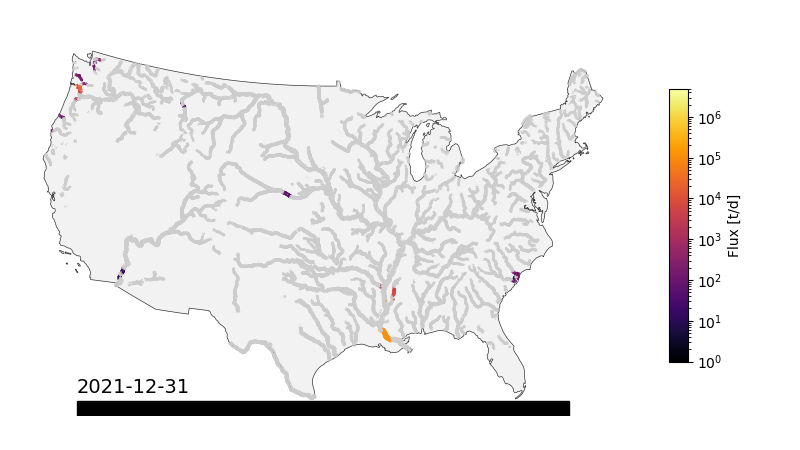

In [4]:
import matplotlib.animation as animation
plt.close('all')

t1 = "2021-01-01"
# t2 = "2019-01-7"
t2 = "2021-12-31"
date_range = pd.date_range(start=t1, end=t2, freq='D')

def get_date_df(date):
    tmp = df[df.index.get_level_values('date') == date].droplevel('date')
    tmp.index = tmp.index.astype(int)
    tmp = tmp.droplevel('Type', axis=1)
    nhd_test = nhd_hybas.merge(tmp, left_on='HYBAS_ID', right_index=True)
    return nhd_test

def map_animation(dates, feat, lim, dt_gray=1):
    # Create an empty plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    
    norm = colors.LogNorm(vmin=lim[0], vmax=lim[1])
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    sm._A = []  # Empty array for the scalar mappable
    cbar = plt.colorbar(sm, ax=ax, shrink=0.65, aspect=15, label='Flux [t/d]')
    
    def draw_year_progress(ax, date):
        year_start = pd.Timestamp(date.year, 1, 1)
        year_end = pd.Timestamp(date.year, 12, 31)
        progress = (date - year_start).days / (year_end - year_start).days

        ax.add_patch(plt.Rectangle((0.1, 0), 0.8, 0.04, fill=False, transform=ax.transAxes))
        ax.add_patch(plt.Rectangle((0.1, 0), 0.8 * progress, 0.04, facecolor='black', transform=ax.transAxes))
        text_str = date.strftime('%Y-%m-%d')
        ax.text(0.1, 0.05, text_str, transform=ax.transAxes, fontsize=14, ha='left', va='bottom')

    # Initialize animation frame
    plot = get_date_df(dates[0]).plot(column=feat, cmap='inferno', norm=norm, ax=ax)
    
    # Data iterator wrapper for frames
    def frames():
        for date in tqdm(dates):
            yield date
            
    # Updates the plot based on the data passed by frames()
    def update(date):
        ax.clear()
        ax.set_axis_off()
        
        date_df = get_date_df(date)
        has_obs = date_df['landsat']>1
        
        plot_kwargs = {
            'column': feat,
            'linewidth': np.log10(date_df['nhd_area'])/2, 
            'cmap': 'inferno', 
            'norm': norm, 
            'ax': ax
        }
        outlines.plot(ax=ax, facecolor=[0.95, 0.95, 0.95], edgecolor=[0.2, 0.2, 0.2], linewidth=0.5)
        
        if mask_dt:
            date_df[has_obs].plot(column='flux',
                                  linewidth= np.log10(date_df[has_obs]['nhd_area'])/2, 
                                  cmap='inferno', 
                                  norm=norm, 
                                  ax=ax)
            date_df[~has_obs].plot(color=[0.8, 0.8, 0.8],
                                   linewidth= np.log10(date_df[~has_obs]['nhd_area'])/2, 
                                   ax=ax)
        else:
            date_df.plot(column='flux',
                         linewidth= np.log10(date_df['nhd_area'])/2, 
                         cmap='inferno', 
                         norm=norm, 
                         ax=ax)
            
        draw_year_progress(ax, date)
        fig.tight_layout()
        
        return plot

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=frames, 
                                interval=1000/10, repeat=True)
    
    return ani

feat = 'flux'
mask_dt=True
ani = map_animation(date_range, feat, [1E0, 5E6], mask_dt)
ani.save(fig_dir / f'2021_{feat}_dt{mask_dt}.mp4', writer='ffmpeg', dpi=300)

In [ ]:
x = 1
x

In [ ]:
ax = plt.gca()

In [ ]:
outlines.plot(facecolor=[0.9, 0.9, 0.9], edgecolor=[0.2, 0.2, 0.2], linewidth=0.5)

In [ ]:
test_df = get_date_df(date_range[0])

In [ ]:
plt.close('all')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

has_obs = test_df['landsat']>0

lim = [1E0, 5E6]
norm = colors.LogNorm(vmin=lim[0], vmax=lim[1])

test_df[has_obs].plot(column='flux', cmap='inferno', norm=norm, ax=ax, alpha=1)
test_df[~has_obs].plot(color=[0.9, 0.9, 0.9], ax=ax)

In [ ]:
plt.close('all')
test_df[has_obs].plot(color=[0.95, 0.95, 0.95])

In [ ]:
(np.log10(test_df['nhd_area'])/2).values

In [ ]:
plt.close('all')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

has_obs = test_df['landsat']>0

lim = [1E0, 5E6]
norm = colors.LogNorm(vmin=lim[0], vmax=lim[1])

plot_kwargs = {
    'column': feat,
    'linewidth': (np.log10(test_df['nhd_area'])/2).values, 
    'cmap': 'inferno', 
    'norm': norm, 
    'ax': ax
}

test_df[has_obs].plot(plot_kwargs)
# test_df[~has_obs].plot(column='flux', cmap='inferno', norm=norm, ax=ax, alpha=0.2)